el dataset fue obtenido desde aqui "https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data".
El objetivo es ver si soy capaz de hacer forecast y predecir el valor del bitcoin.

In [2]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
# Cargamos el csv
train = pd.read_csv('btcusd_1-min_data.csv')

print(train.shape)

# Mostramos 10 registros al azar
train.sample(10)

(6750281, 6)


,Timestamp,Open,High,Low,Close,Volume
3970391,1.563661e+09,10933.03,10933.03,10932.14,10932.14,2.734059
4917153,1.620474e+09,58266.61,58266.61,58236.41,58248.35,2.194103
5056575,1.628839e+09,45276.58,45289.80,45251.50,45268.80,2.852889
345987,1.346171e+09,11.06,11.06,11.06,11.06,0.000000
122101,1.332738e+09,4.54,4.54,4.54,4.54,0.000000
6693356,1.728204e+09,61994.00,61994.00,61993.00,61993.00,0.038263
3414057,1.530277e+09,5897.14,5897.69,5896.31,5896.65,2.025565
386530,1.348604e+09,11.96,11.96,11.96,11.96,0.000000
413461,1.350220e+09,11.89,11.89,11.89,11.89,0.000000
4242686,1.580002e+09,8338.61,8342.64,8338.61,8338.62,1.239172


despues de ver la tabla me voy a centrar en el valor de cierre y es lo que voy a tratar como target
las columnas son: 
Timestamp: el tiempo
Open: el valor cuando empezo a tomar el tiempo
High: el valor mas alto que tomo durante ese tiempo
Low: el valor mas bajo que tomo durante todo ese tiempo
Close: el valor con el que finalizo el tiempo
Volume: transancciones durante ese tiempo

In [4]:
#miro donde hay nulls si los hay
train.isna().sum()

Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

In [5]:
filas_con_nulos = train[train.isnull().any(axis=1)]
print(filas_con_nulos)

         Timestamp     Open     High      Low    Close    Volume
6750280        NaN  57854.0  57864.0  57835.0  57835.0  1.353466


In [6]:
train = train.dropna()
print(train)

            Timestamp       Open       High        Low      Close    Volume
0        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
1        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
2        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
3        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
4        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
...               ...        ...        ...        ...        ...       ...
6750275  1.737936e+09  102518.00  102559.00  102506.00  102558.00  0.771165
6750276  1.737936e+09  102628.00  102669.00  102608.00  102611.00  0.086742
6750277  1.737936e+09  102659.00  102712.00  102657.00  102712.00  0.488757
6750278  1.737936e+09  102631.00  102631.00  102573.00  102573.00  0.126719
6750279  1.737936e+09  102573.00  102604.00  102507.00  102514.00  0.474495

[6750280 rows x 6 columns]


si bien podria poner el timestamp del unico valor con un null, dicidi borrarlo, un registro arriba o abajo de 6 millones creo que no va a influir

In [8]:
train['Timestamp'] = pd.to_datetime(train['Timestamp'], unit='s') 
train.set_index('Timestamp', inplace=True)
print(train)

                          Open       High        Low      Close    Volume
Timestamp                                                                
2012-01-01 10:01:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:02:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:03:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:04:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:05:00       4.58       4.58       4.58       4.58  0.000000
...                        ...        ...        ...        ...       ...
2025-01-26 23:56:00  102518.00  102559.00  102506.00  102558.00  0.771165
2025-01-26 23:57:00  102628.00  102669.00  102608.00  102611.00  0.086742
2025-01-26 23:58:00  102659.00  102712.00  102657.00  102712.00  0.488757
2025-01-26 23:59:00  102631.00  102631.00  102573.00  102573.00  0.126719
2025-01-27 00:00:00  102573.00  102604.00  102507.00  102514.00  0.474495

[6750280 rows x 5 columns]


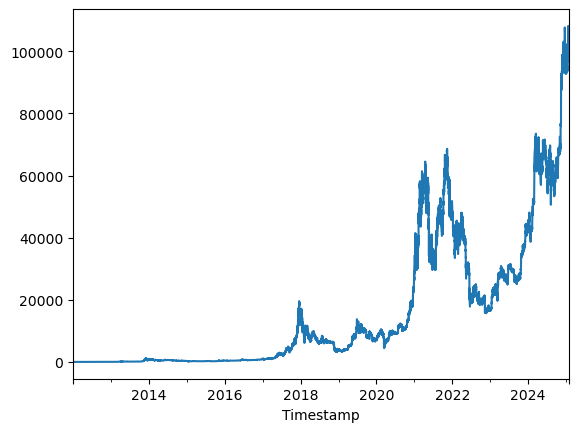

In [9]:
# Calcular la media por hora y rellenar posibles nulos
data_hour = train['Close'].resample('h').mean().ffill()

# Visualizamos la serie completa
data_hour.plot()
plt.show()

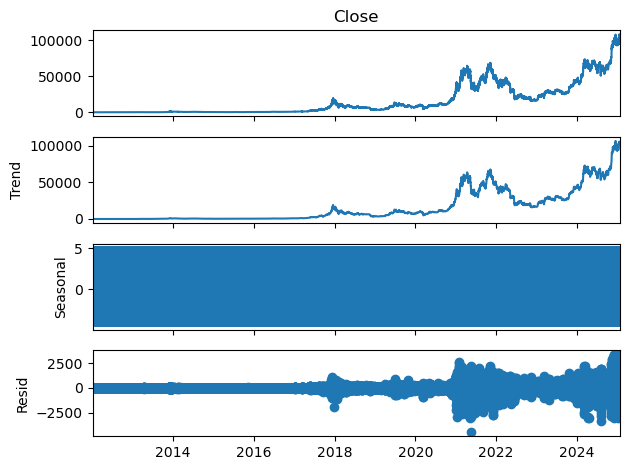

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomposición aditiva
resultado = seasonal_decompose(data_hour, model='additive')

# Representamos cada componente
resultado.plot()
plt.tight_layout()
plt.show()

In [11]:
print(data_hour)

Timestamp
2012-01-01 10:00:00         4.580000
2012-01-01 11:00:00         4.580000
2012-01-01 12:00:00         4.580000
2012-01-01 13:00:00         4.580000
2012-01-01 14:00:00         4.580000
                           ...      
2025-01-26 20:00:00    105046.750000
2025-01-26 21:00:00    104778.150000
2025-01-26 22:00:00    104516.550000
2025-01-26 23:00:00    103059.166667
2025-01-27 00:00:00    102514.000000
Freq: h, Name: Close, Length: 114591, dtype: float64


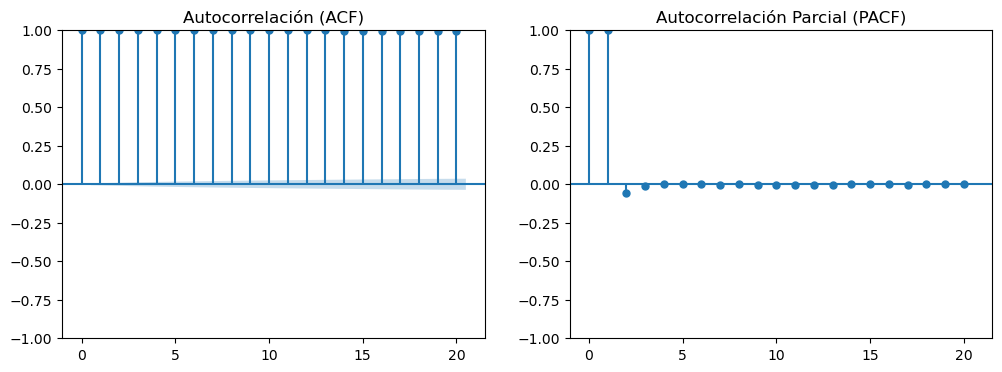

In [12]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(data_hour, lags=20, ax=ax[0])
ax[0].set_title("Autocorrelación (ACF)")

plot_pacf(data_hour, lags=20, ax=ax[1])
ax[1].set_title("Autocorrelación Parcial (PACF)")

plt.show()

In [13]:
# 1 año a considerar en el conjunto de test
n_steps = 24 * 364

# Dividimos la serie en train y test
train_size = len(data_hour) - n_steps
train, test = data_hour[:train_size], data_hour[train_size:]

# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(2, 2, 1))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

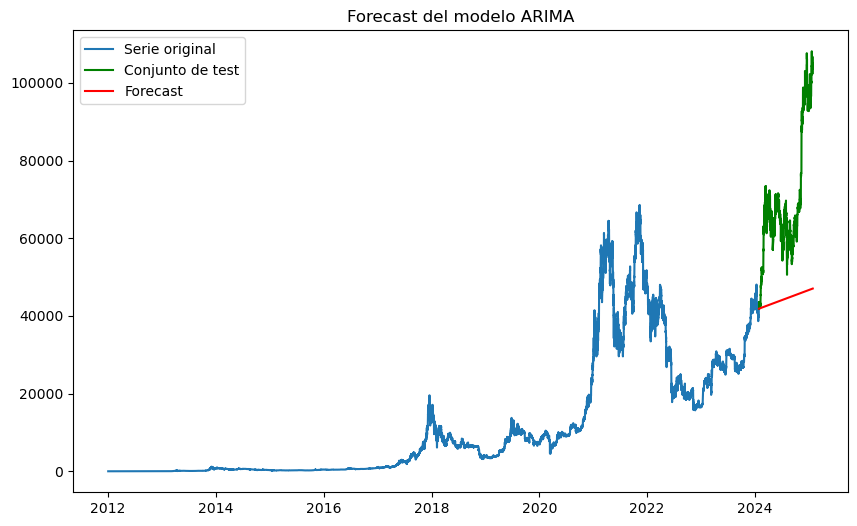

Mean Absolute Error: 25569.249204460215


In [14]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [15]:
model = SARIMAX(train, order=(2, 2, 1), seasonal_order=(2, 2, 1, 12))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

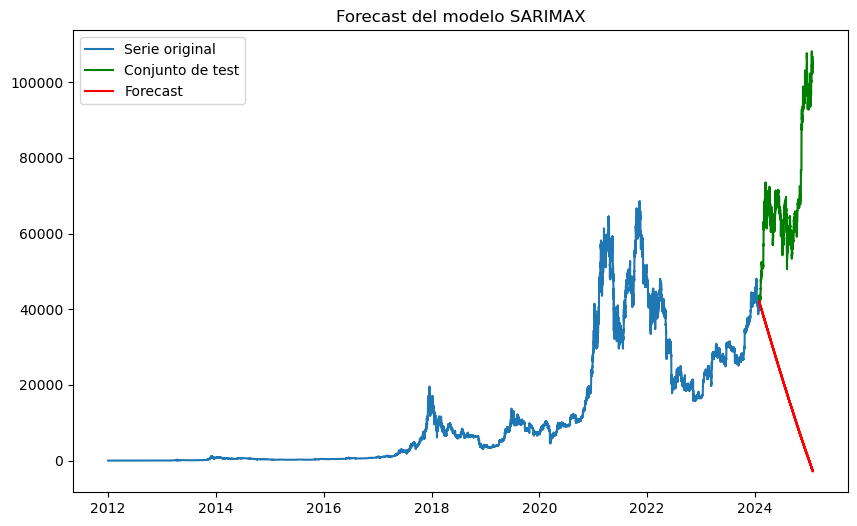

Mean Absolute Error: 51017.9356679501


In [16]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo SARIMAX')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

# Aplicar auto_arima para encontrar los mejores parámetros
modelo_auto = auto_arima(data_hour, 
                         seasonal=False,  
                         stepwise=True,   
                         trace=True,
                         error_action='ignore', 
                         suppress_warnings=True)

# Mostrar resumen del modelo seleccionado
print(modelo_auto.summary())

# Obtener los parámetros óptimos
p, d, q = modelo_auto.order

In [18]:
# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(1,1,2)) #poner p d y q en caso de ejecutar auto_arima
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

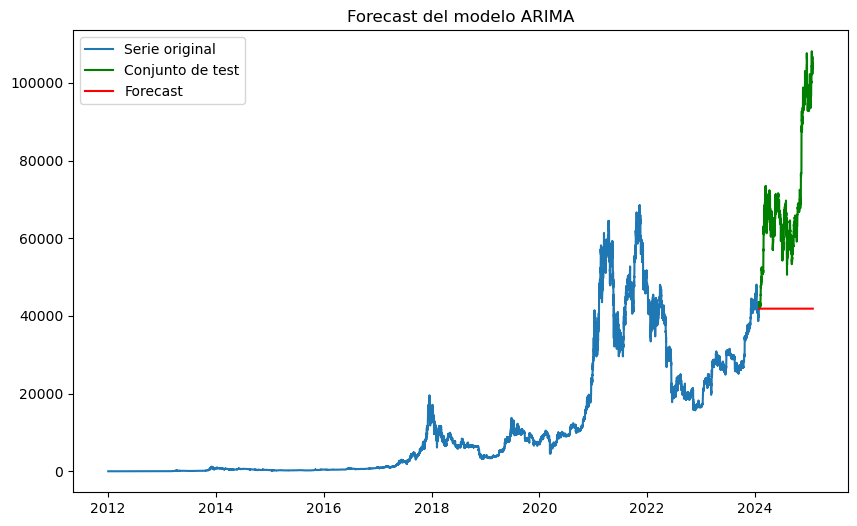

Mean Absolute Error: 28157.11822132116


In [19]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [24]:
# Probar con m=24 (patrón diario)
#model_daily = auto_arima(data_hour,seasonal=False,stepwise=True,trace=True,error_action='ignore',m=24,suppress_warnings=True)

#p, d, q = model_daily.order
#print(model_daily.summary())
# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(1,1,2)) #poner p d y q en caso de ejecutar auto_arima
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

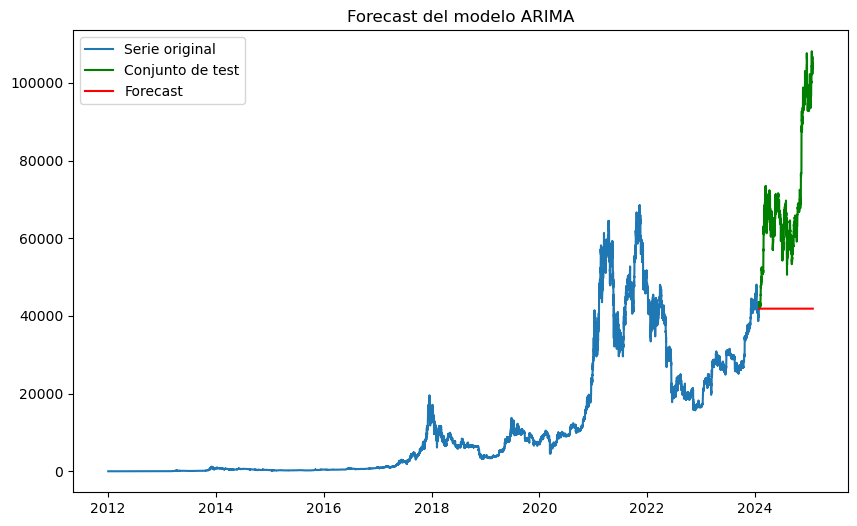

Mean Absolute Error: 28157.11822132116


In [25]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [32]:
model = SARIMAX(train, order=((1,1,2)), seasonal_order=(1,1,2,24))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

MemoryError: Unable to allocate 4.56 GiB for an array with shape (105855, 76, 76) and data type float64

In [ ]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo SARIMAX')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [ ]:
# Probar con m=168 (patrón semanal)
model_weekly = auto_arima(data_hour,seasonal=False, stepwise=True, trace=True, error_action='ignore', m=168, suppress_warnings=True)

p, d, q = model_weekly.order
print(model_weekly.summary())
# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(p, d, q)) #poner p d y q en caso de ejecutar auto_arima
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

In [ ]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [ ]:
model = SARIMAX(train, order=(p, d, q), seasonal_order=(p, d, q, 168))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

In [ ]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo SARIMAX')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [ ]:
# Probar con m=24 * 30 (patrón mensual)
model_weekly = auto_arima(data_hour,  
                         seasonal=False,  
                         stepwise=True,   
                         trace=True,
                         error_action='ignore',
                         m=24 * 30,
                         suppress_warnings=True)

p, d, q = model_weekly.order
print(model_weekly.summary())
# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(p, d, q)) #poner p d y q en caso de ejecutar auto_arima
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

In [ ]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [ ]:
model = SARIMAX(train, order=(p, d, q), seasonal_order=(p, d, q, 24 * 30))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

In [ ]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo SARIMAX')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')